In [2]:
import numpy as np
import pandas as pd

import networkx as nx

import scipy

import multiprocessing

from matplotlib import pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import seaborn as sns

from utils import data
from utils.hyperbolic_utils import hyperbolicity_sample

In [3]:
data_path = "./data"
tissue_hierarchy, ppi_networks, labels = data.read_data(data_path)

Read data:
	Tissue hierarchy with 219 nodes.
	144 tissue-specific PPI networks, with an average of 1906.99 nodes and 25462.24 edges.
	503 tissue-specific cellular functions (with 420 unique functions) covering 48 distinct tissues.


# Degree distribution

## Separately for each layer

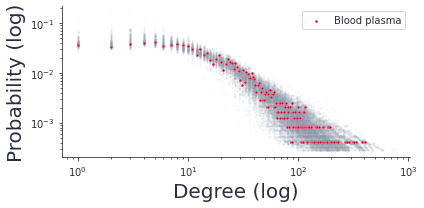

In [5]:
plt.figure(figsize=(6,3))
ax = plt.gca()

for i, (tissue, G) in enumerate(ppi_networks.items()):
    degree_sequence = sorted((d for n, d in G.degree()), reverse=True)
    degrees, degree_numbers = np.unique(degree_sequence, return_counts=True)
    sns.scatterplot(x=degrees, y=degree_numbers / degree_numbers.sum(), alpha = 0.1, s=4, color="#8D99AE", ax=ax)

G = ppi_networks["blood_plasma"]
degree_sequence = sorted((d for n, d in G.degree()), reverse=True)
degrees, degree_numbers = np.unique(degree_sequence, return_counts=True)
sns.scatterplot(x=degrees, y=degree_numbers / degree_numbers.sum(), alpha = 1.0, s=8, color="#D90429", label = "Blood plasma", ax=ax)

ax.spines[['top', 'right']].set_visible(False)
ax.set_xlabel('Degree (log)', fontsize=20)
ax.set_ylabel('Probability (log)', fontsize=20)
ax.legend(fontsize="12", loc ="upper right")
ax.set_xscale("log")
ax.set_yscale("log")

c = "#2B2D42"
for text in ax.legend().get_texts():
    text.set_color(c)
ax.spines['bottom'].set_color(c)
ax.spines['left'].set_color(c)
ax.xaxis.label.set_color(c)
ax.tick_params(axis='x', colors=c)
ax.yaxis.label.set_color(c)
ax.tick_params(axis='y', colors=c)

plt.tight_layout()
plt.savefig('results/FigData1.png', dpi = 600)
plt.show()

## Inter-layer correlation

In [6]:
degrees = []
for tissue, G in ppi_networks.items():
    for n, d in G.degree():
        tissue = n.split('__')[0]
        gene = n.split('__')[1]
        degrees.append({
            'tissue': tissue,
            'gene': gene,
            'degree': d
        })

df_degree_long = pd.DataFrame(degrees)
df_degree = df_degree_long.pivot(index='gene', columns='tissue', values='degree')

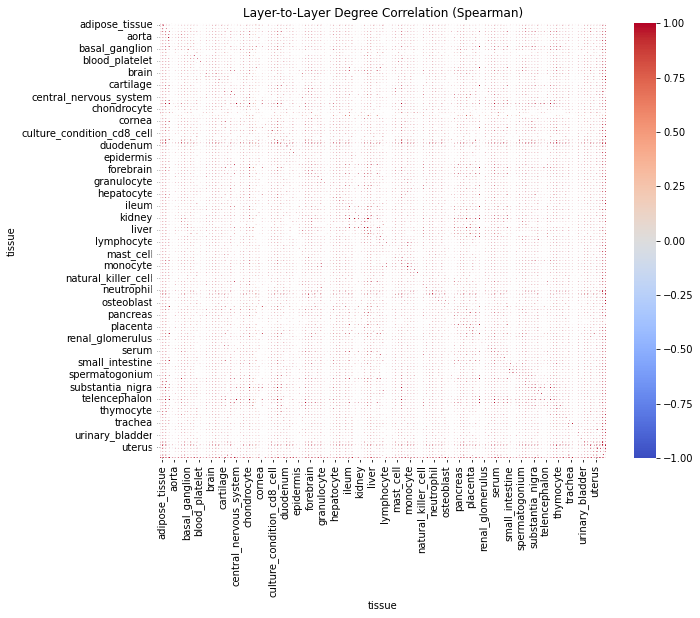

Mean inter-layer correlation: 0.974


In [13]:
correlation_matrix = df_degree.corr(method='spearman')

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Layer-to-Layer Degree Correlation (Spearman)')
plt.show()

mean_corr = correlation_matrix.where(np.triu(np.ones(correlation_matrix.shape), 1).astype(bool)).mean().mean()
print(f"Mean inter-layer correlation: {mean_corr:.3f}")

Mean coefficient of variation across tissues: 0.20


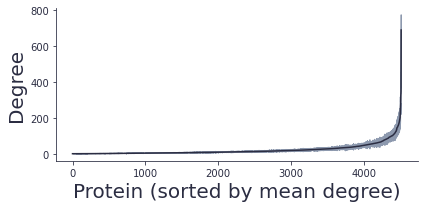

In [ ]:
node_means = df_degree.mean(axis=1)
node_stds = df_degree.std(axis=1)

sorted_nodes = node_means.sort_values().index
sorted_means = node_means.loc[sorted_nodes]
sorted_stds = node_stds.loc[sorted_nodes]

variation_ratio = (node_stds / node_means).dropna()
print(f"Mean coefficient of variation across tissues: {variation_ratio.mean():.2f}")

plt.figure(figsize=(6, 3))
ax = plt.gca()

plt.plot(sorted_means.values, color='#2B2D42', linewidth=1.5)
plt.fill_between(range(len(sorted_means)), sorted_means - sorted_stds, sorted_means + sorted_stds, color='#8D99AE')

ax.spines[['top', 'right']].set_visible(False)
ax.set_xlabel('Protein (sorted by mean degree)', fontsize=20)
ax.set_ylabel('Degree', fontsize=20)

c = "#2B2D42"
ax.spines['bottom'].set_color(c)
ax.spines['left'].set_color(c)
ax.xaxis.label.set_color(c)
ax.tick_params(axis='x', colors=c)
ax.yaxis.label.set_color(c)
ax.tick_params(axis='y', colors=c)

plt.tight_layout()
plt.savefig('results/FigData2.png', dpi = 600)
plt.show()

## Correlation along the hierarchy tree

In [14]:
def flatten_pairwise_matrix_with_labels(corr_df, dist_df):
    arr_corr = corr_df.to_numpy()
    arr_dist = dist_df.to_numpy()
    i_upper, j_upper = np.triu_indices_from(arr_corr, k=1)

    flattened = pd.DataFrame({
        'distance': arr_dist[i_upper, j_upper],
        'correlation': arr_corr[i_upper, j_upper],
    })
    return flattened


all_dists = dict(nx.all_pairs_shortest_path_length(tissue_hierarchy.to_undirected()))
df_distance = pd.DataFrame(all_dists)

tissues = list(correlation_matrix.columns)
df_distance = df_distance.loc[tissues, tissues]

df_pairs = flatten_pairwise_matrix_with_labels(correlation_matrix, df_distance)

mean_corr_by_dist = df_pairs.groupby('distance', sort=True)['correlation'].mean().reset_index()

rho, pval = scipy.stats.spearmanr(df_pairs['distance'], df_pairs['correlation'])
print(f"Spearman rho = {rho:.3f}, p-value = {pval:.3g}")


Spearman rho = -0.185, p-value = 1.28e-79


In [ ]:
plt.figure(figsize=(14, 6))
sns.violinplot(data=df_pairs, x='distance', y='correlation', inner='box', cut=0)
plt.title("Violin Plot of Correlation by Tree Distance")
plt.grid(True)
plt.tight_layout()
plt.show()

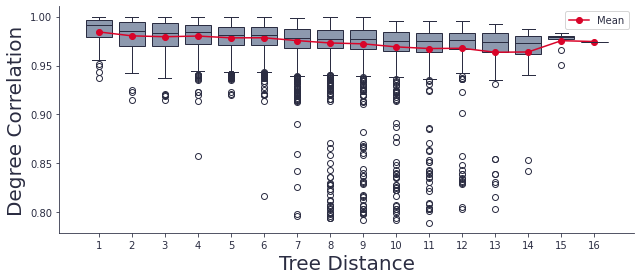

In [23]:
plt.figure(figsize=(9, 4))
ax = plt.gca()

sns.boxplot(data=df_pairs, x='distance', y='correlation', ax=ax,
            showfliers=True, color='#8d99ae', saturation=1.0, linecolor='#2B2D42')

plt.plot(mean_corr_by_dist['correlation'], color='#d90429', label='Mean', marker='o')

ax.spines[['top', 'right']].set_visible(False)
ax.legend(fontsize="12", loc ="lower left")
ax.set_xlabel("Tree Distance", fontsize=20)
ax.set_ylabel("Degree Correlation", fontsize=20)

c = "#2B2D42"
for text in ax.legend().get_texts():
    text.set_color(c)
ax.spines['bottom'].set_color(c)
ax.spines['left'].set_color(c)
ax.xaxis.label.set_color(c)
ax.tick_params(axis='x', colors=c)
ax.yaxis.label.set_color(c)
ax.tick_params(axis='y', colors=c)

plt.tight_layout()
plt.savefig('results/FigData3.png', dpi = 600)
plt.show()

# Gromov's delta

In [9]:
with multiprocessing.Pool(30) as p:
   gromov_deltas = p.map(hyperbolicity_sample, [net for net in ppi_networks.values()])

In [11]:
print(np.mean(gromov_deltas))

1.1840277777777777
